<a href="https://colab.research.google.com/github/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/blob/main/THOMAS_MVP_SPRINT_3_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MVP Machine Learning & Analytics**<br>
<hr>
Versão: 1.0

**Nome:** Thomas Alves de Souza Abrantes  
**Matrícula:** 4052025000680 (RA)

**Dataset:** Datasets extraídos do Portal Dados Abertos do Governo Federal.  

*  **Fonte dos dados:** https://dados.gov.br/dados/conjuntos-dados/ocorrencias-aeronauticas-da-aviacao-civil-brasileira
*  O link abre os arquivos disponibilizados pelo CENIPA, contendo informações das ocorrências aeronáuticas na aviação Civil Brasileira, separados em 5 arquivos:
    *  Aeronaves
    *  Dados da ocorrência
    *  Tipo de ocorrência
    *  Fator contribuinte
    *  Recomendações
  
Os dados em cada arquivo serão analisados com mais detalhes após a carga.  
A imagem abaixo ilustra o modelo de dados dos arquivos (datasets).

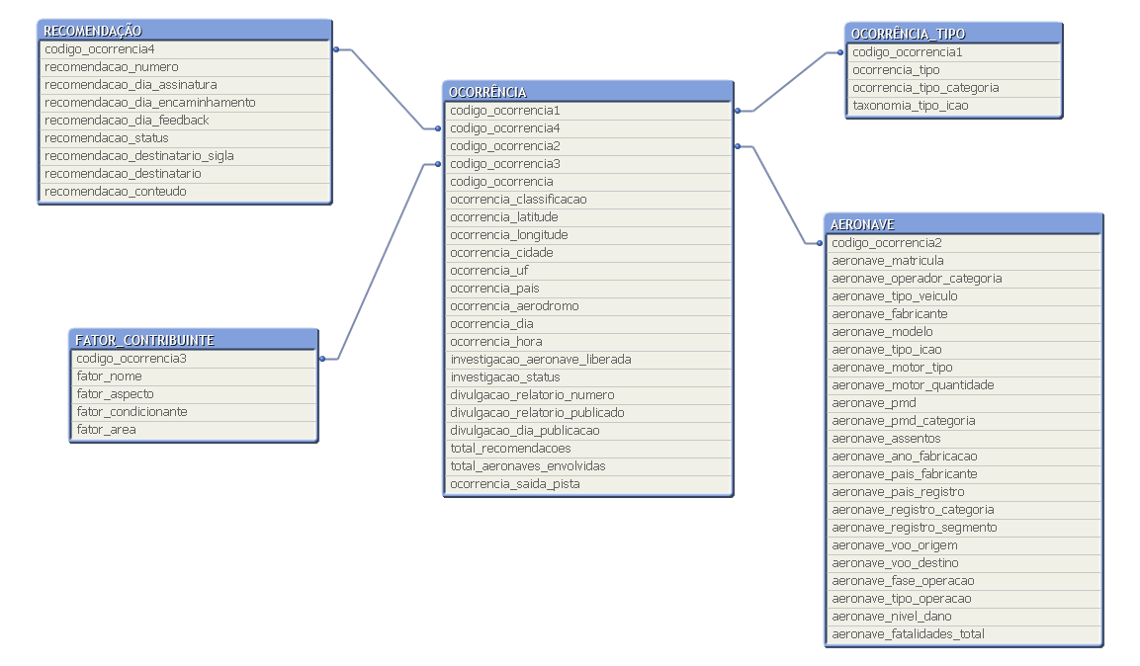

#**Introdução e Objetivos**

O objetivo principal deste projeto é criar um modelo preditivo robusto para classificar a gravidade de ocorrências aeronáuticas no Brasil em três categorias:
*  Acidente
*  Incidente Grave
*  Incidente

Uma classificação precisa é vital para a segurança operacional e para a eficiente alocação de recursos de investigação.

Com base nos dados do CENIPA, o modelo utiliza características detalhadas da aeronave e da ocorrência. As variáveis incluem o Nível de Dano (que se provou o fator de maior peso na classificação), o tipo de falha, o ano de fabricação e a capacidade de passageiros.

O objetivo é desenvolver uma ferramenta capaz de diferenciar as três classes de forma consistente e com alta confiabilidade, fornecendo uma valiosa análise preditiva para o sistema de segurança aeronáutica.

#**Observação**

A seção **Comparando os modelos XGBoost, LightGBM e Random Forest** é a etapa de maior consumo de tempo, com uma execução de aproximadamente 10 minutos e **deixei o código comentado** pois em alguns casos esta dando erro de **falta de memória RAM**.  

Para otimizar o fluxo de trabalho e focar na conclusão, deixei uma cópia do **RESULTADO** (F1-Score, Acurácia e Tempo de Treino) de cada modelo. Esta comparação direta é essencial para justificar tecnicamente a escolha do algoritmo final.  

**Todos os modelos treinados estão salvos**, e o código para salvar, realizar o download e carregar o modelo treinado está comentado no notebook, caso seja necessário reralizar algumas destas etapas.

#**Configuração do notebook**

##Bibliotecas

Instalações necessárias:
*  **XGBoost:** Biblioteca de código aberto e um algoritmo de machine learning que implementa a técnica de gradient boosting para resolver problemas de regressão e classificação, especialmente em dados tabulares.
*  **imbalanced-learn:** Biblioteca Python de código aberto projetada para ajudar a resolver problemas de desequilíbrio de classes em aprendizado de máquina. A biblioteca fornece ferramentas e algoritmos para processar conjuntos de dados desbalanceados e melhorar o desempenho do modelo.

In [2]:
!pip install xgboost
!pip install imbalanced-learn

Importações

In [3]:
# Bibliotecas do notebook
import joblib
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import joblib
import requests
import time
import lightgbm as lgbm
import gc

# Omite warning de deprecated no pandas
warnings.filterwarnings('ignore', category=DeprecationWarning, module='pandas')

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from google.colab import files
from io import BytesIO
from sklearn.metrics import f1_score, accuracy_score
from lightgbm import LGBMClassifier

##Variáveis globais

In [4]:
# URLs dos arquivos raw no repositório do GitHub
URL_AERONAVES = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/aeronave.csv'
URL_OCORRENCIA = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/ocorrencia.csv'
URL_OCORRENCIA_TIPO = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/ocorrencia_tipo.csv'
URL_FATOR_CONTRIBUINTE = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/fator_contribuinte.csv'
URL_RECOMENDACAO = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/recomendacao.csv'

#Mensagens
MSG_DATAFRAME_LIMPO_SUFIX = 'sem valores Nulos'
MSG_LISTA_VALORES_COLUNA = 'Lista de todos os valores da coluna'
MSG_A_PREVISAO_DO_MODELO_E = 'A previsão para o novo dado é:'
MSG_TOTAL_REGISTROS = 'Total de registros'
MSG_TOTAL_COLUNAS = 'Total de colunas'
MSG_DADOS_NULOS_POR_COLUNA = 'Dados de Nulos por Coluna'

#Dataframes
DATAFRAME_CONSOLIDADO = 'Dataframe Consolidado'
DATAFRAME_AERONAVES = 'Dataframe Aeronaves'
DATAFRAME_OCORRENCIAS = 'Dataframe Ocorrências'
DATAFRAME_TIPO_OCORRENCIA = 'Dataframe Tipo de Ocorrência'
DATAFRAME_FATOR_CONTRIBUINTE = 'Dataframe Fator Contribuinte'
DATAFRAME_RECOMENDACAO = 'Dataframe Recomendação'
DATAFRAME_AERONAVES_SEM_NULOS = DATAFRAME_AERONAVES + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_OCORRENCIAS_SEM_NULOS = DATAFRAME_OCORRENCIAS + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_TIPO_OCORRENCIAS_SEM_NULOS = DATAFRAME_TIPO_OCORRENCIA + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_RECOMENDACAO_SEM_NULOS = DATAFRAME_RECOMENDACAO + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_FATOR_CONTRIBUINTE_SEM_NULOS = DATAFRAME_FATOR_CONTRIBUINTE + ' ' + MSG_DATAFRAME_LIMPO_SUFIX

# Coluna
COLUNA_PERCENTUAL_DE_VALORES_NULOS = 'percentual de valores nulos'

# Outros
ENCODING_LATIN = 'latin1'
SEPARADOS_CSV = ';'
ON_BAD_LINES_SKIP = 'skip'

CARACTERES_PROIBIDOS = r'[\[\]<>,:="\'\s]'
SUBSTITUIR_POR = '_'

##Funções

In [5]:
#Imprime linhas pontilhadas para separação de mensagens
def separadorLinha(adicionarMaisUmaLinhaVazia = False):
  print("-" * 100)
  if (adicionarMaisUmaLinhaVazia is True):
      print("\n")

def analisar_nulos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analisa e retorna um DataFrame com a contagem e o percentual
    de valores nulos de cada coluna.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.

    Returns:
        pd.DataFrame: Um novo DataFrame com as colunas 'coluna', 'nulos'
                      e 'percentual de valores nulos'.
    """

    # Conta a quantidade de valores nulos em cada coluna
    nulos_por_coluna = df.isnull().sum()

    # Filtra apenas as colunas com valores nulos
    colunas_com_nulos = nulos_por_coluna[nulos_por_coluna > 0]

    # Se não houver colunas com nulos, retorna um DataFrame vazio
    if colunas_com_nulos.empty:
        return pd.DataFrame(columns=['coluna', 'nulos', 'percentual de valores nulos'])

    # Calcula o percentual de nulos
    total_registros = len(df)
    percentual_nulos = (colunas_com_nulos / total_registros) * 100

    # Cria o DataFrame final com os resultados
    df_nulos = pd.DataFrame({
        'coluna': colunas_com_nulos.index,
        'nulos': colunas_com_nulos.values,
        'percentual de valores nulos': percentual_nulos.values
    })

    # Arredonda o percentual para duas casas decimais
    df_nulos['percentual de valores nulos'] = df_nulos['percentual de valores nulos'].round(2)

    return df_nulos


#**Carga dos Dados**

In [6]:
# Carregando os dataFrames
df_aeronaves = pd.read_csv(URL_AERONAVES, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_ocorrencias = pd.read_csv(URL_OCORRENCIA, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_ocorrencia_tipo = pd.read_csv(URL_OCORRENCIA_TIPO, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_fator_contribuinte = pd.read_csv(URL_FATOR_CONTRIBUINTE, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_recomendacao = pd.read_csv(URL_RECOMENDACAO, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)

# Exibindo as primeiras linhas para confirmar o carregamento
print(DATAFRAME_AERONAVES)
separadorLinha()
print(df_aeronaves.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_OCORRENCIAS)
separadorLinha()
print(df_ocorrencias.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
print(df_ocorrencia_tipo.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_RECOMENDACAO)
separadorLinha()
print(df_recomendacao.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(df_fator_contribuinte.head().to_string(index=False))
separadorLinha(True)

Dataframe Aeronaves
----------------------------------------------------------------------------------------------------
 codigo_ocorrencia2 aeronave_matricula aeronave_operador_categoria aeronave_tipo_veiculo                    aeronave_fabricante   aeronave_modelo aeronave_tipo_icao aeronave_motor_tipo aeronave_motor_quantidade  aeronave_pmd  aeronave_pmd_categoria  aeronave_assentos  aeronave_ano_fabricacao aeronave_pais_fabricante aeronave_pais_registro aeronave_registro_categoria aeronave_registro_segmento                     aeronave_voo_origem            aeronave_voo_destino aeronave_fase_operacao aeronave_tipo_operacao aeronave_nivel_dano  aeronave_fatalidades_total
              87125              PSAEX                         ***                 AVIÃO                                EMBRAER       ERJ 190-400               E295                 NaN                       ***       61200.0                 61200.0                0.0                   2024.0                   BRASIL

#**Avaliando cada dataframe criado com os dados carregados**

###Dataframe Aeronaves

Estrutura

In [7]:
print(DATAFRAME_AERONAVES)
separadorLinha()
df_aeronaves.info()

Dataframe Aeronaves
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13301 entries, 0 to 13300
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   codigo_ocorrencia2           13301 non-null  int64  
 1   aeronave_matricula           13300 non-null  object 
 2   aeronave_operador_categoria  13292 non-null  object 
 3   aeronave_tipo_veiculo        13300 non-null  object 
 4   aeronave_fabricante          13296 non-null  object 
 5   aeronave_modelo              13291 non-null  object 
 6   aeronave_tipo_icao           13290 non-null  object 
 7   aeronave_motor_tipo          12828 non-null  object 
 8   aeronave_motor_quantidade    13300 non-null  object 
 9   aeronave_pmd                 13300 non-null  float64
 10  aeronave_pmd_categoria       13300 non-null  float64
 11  aeronave_as

Listando as primeiras linhas do df_aeronaves.


In [8]:
df_aeronaves.head()

,codigo_ocorrencia2,aeronave_matricula,aeronave_operador_categoria,aeronave_tipo_veiculo,aeronave_fabricante,aeronave_modelo,aeronave_tipo_icao,aeronave_motor_tipo,aeronave_motor_quantidade,aeronave_pmd,...,aeronave_pais_fabricante,aeronave_pais_registro,aeronave_registro_categoria,aeronave_registro_segmento,aeronave_voo_origem,aeronave_voo_destino,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total
0,87125,PSAEX,***,AVIÃO,EMBRAER,ERJ 190-400,E295,NaN,***,61200.0,...,BRASIL,BRASIL,AVIÃO,***,VIRACOPOS,ORLANDO BEZERRA DE MENEZES,DESCIDA,REGULAR,NENHUM,0.0
1,87124,PRYXD,***,AVIÃO,ATR - GIE AVIONS DE TRANSPORT RÉGIONAL,ATR-72-212A (600),AT76,***,***,23000.0,...,BRASIL,BRASIL,AVIÃO,***,TENENTE-CORONEL AVIADOR CÉSAR BOMBONATO,TANCREDO NEVES,SUBIDA,REGULAR,NENHUM,0.0
2,87123,PRXBT,***,***,AIRBUS S.A.S.,A320-271N,A20N,NaN,BIMOTOR,79000.0,...,BRASIL,BRASIL,***,***,GOVERNADOR ANDRÉ FRANCO MONTORO,PINTO MARTINS,DECOLAGEM,REGULAR,NENHUM,0.0
3,87122,PRAKJ,***,AVIÃO,ATR - GIE AVIONS DE TRANSPORT RÉGIONAL,ATR-72-212A (600),AT76,TURBOÉLICE,BIMOTOR,22000.0,...,BRASIL,BRASIL,AVIÃO,***,SANTA MARIA,VIRACOPOS,DECOLAGEM,REGULAR,NENHUM,0.0
4,87121,PRMHK,***,AVIÃO,AIRBUS,A320-214,A320,JATO,BIMOTOR,77000.0,...,BRASIL,BRASIL,AVIÃO,***,PROFESSOR ERIBERTO MANOEL REINO,GOVERNADOR ANDRÉ FRANCO MONTORO,DECOLAGEM,REGULAR,LEVE,0.0


###Dataframe Ocorrências

Estrutura

In [9]:
print(DATAFRAME_OCORRENCIAS)
separadorLinha()
df_ocorrencias.info()

Dataframe Ocorrências
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13185 entries, 0 to 13184
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   codigo_ocorrencia               13185 non-null  int64 
 1   codigo_ocorrencia1              13185 non-null  int64 
 2   codigo_ocorrencia2              13185 non-null  int64 
 3   codigo_ocorrencia3              13185 non-null  int64 
 4   codigo_ocorrencia4              13185 non-null  int64 
 5   ocorrencia_classificacao        13185 non-null  object
 6   ocorrencia_latitude             10425 non-null  object
 7   ocorrencia_longitude            10425 non-null  object
 8   ocorrencia_cidade               13185 non-null  object
 9   ocorrencia_uf                   13185 non-null  object
 10  ocorrencia_pais                 13185 non-n

Listando as primeiras linhas df_ocorrencias

In [10]:
df_ocorrencias.head()

,codigo_ocorrencia,codigo_ocorrencia1,codigo_ocorrencia2,codigo_ocorrencia3,codigo_ocorrencia4,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,...,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista
0,87125,87125,87125,87125,87125,INCIDENTE,-7.219166666666,-39.26944444444,JUAZEIRO DO NORTE,CE,...,11/05/2025,04:20:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
1,87124,87124,87124,87124,87124,INCIDENTE,-18.88361111111,-48.22527777777,UBERLÂNDIA,MG,...,08/05/2025,14:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
2,87123,87123,87123,87123,87123,INCIDENTE,-23.43555555555,-46.47305555555,GUARULHOS,SP,...,09/05/2025,18:45:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
3,87122,87122,87122,87122,87122,INCIDENTE,-29.71083333333,-53.69222222222,SANTA MARIA,RS,...,04/05/2025,14:45:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO
4,87121,87121,87121,87121,87121,INCIDENTE,-20.81722222222,-49.40694444444,SÃO JOSÉ DO RIO PRETO,SP,...,10/05/2025,10:00:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO


###DataFrame Tipo de Ocorrência

Estrutura

In [11]:
print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
df_ocorrencia_tipo.info()

Dataframe Tipo de Ocorrência
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13900 entries, 0 to 13899
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   codigo_ocorrencia1         13900 non-null  int64 
 1   ocorrencia_tipo            13895 non-null  object
 2   ocorrencia_tipo_categoria  13895 non-null  object
 3   taxonomia_tipo_icao        13895 non-null  object
dtypes: int64(1), object(3)
memory usage: 434.5+ KB


Listando as primeiras linhas df_ocorrencia_tipo

In [12]:
df_ocorrencia_tipo.head()

,codigo_ocorrencia1,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao
0,87125,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
1,87124,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
2,87123,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP
3,87122,FALHA OU MAU FUNCIONAMENTO DO MOTOR,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP
4,87121,COLISÃO COM AVE,COLISÃO COM AVE,BIRD


##Dataframe Fator Contribuinte

Estrutura

In [13]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
df_fator_contribuinte.info()

Dataframe Fator Contribuinte
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8613 entries, 0 to 8612
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   codigo_ocorrencia3   8613 non-null   int64 
 1   fator_nome           8613 non-null   object
 2   fator_aspecto        8613 non-null   object
 3   fator_condicionante  8613 non-null   object
 4   fator_area           8613 non-null   object
dtypes: int64(1), object(4)
memory usage: 336.6+ KB


Listando as primeiras linhas df_fator_contribuinte

In [14]:
df_fator_contribuinte.head()

,codigo_ocorrencia3,fator_nome,fator_aspecto,fator_condicionante,fator_area
0,85239,APLICAÇÃO DE COMANDOS,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL
1,85239,ATITUDE,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
2,85239,CONDIÇÕES METEOROLÓGICAS ADVERSAS,ELEMENTOS RELACIONADOS AO AMBIENTE OPERACIONAL,***,FATOR OPERACIONAL
3,85239,PERCEPÇÃO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO
4,85239,PROCESSO DECISÓRIO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO


##Dataframe Recomendação

Estrutura

In [15]:
print(DATAFRAME_RECOMENDACAO)
separadorLinha()
df_recomendacao.info()

Dataframe Recomendação
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388 entries, 0 to 3387
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   codigo_ocorrencia4               3387 non-null   object
 1   recomendacao_numero              2890 non-null   object
 2   recomendacao_dia_assinatura      2890 non-null   object
 3   recomendacao_dia_encaminhamento  2890 non-null   object
 4   recomendacao_dia_feedback        2217 non-null   object
 5   recomendacao_conteudo            2889 non-null   object
 6   recomendacao_status              2889 non-null   object
 7   recomendacao_destinatario_sigla  2889 non-null   object
 8   recomendacao_destinatario        2889 non-null   object
dtypes: object(9)
memory usage: 238.3+ KB


Listando as primeiras linhas df_recomendacao

In [16]:
df_recomendacao.head()

,codigo_ocorrencia4,recomendacao_numero,recomendacao_dia_assinatura,recomendacao_dia_encaminhamento,recomendacao_dia_feedback,recomendacao_conteudo,recomendacao_status,recomendacao_destinatario_sigla,recomendacao_destinatario
0,84857,A-092/CENIPA/2024 - 01,2025-04-22,2025-04-23,NaN,Divulgar os ensinamentos colhidos na presente ...,AGUARDANDO RESPOSTA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
1,83193,A-014/CENIPA/2024 - 01,2025-02-17,2025-02-19,NaN,Divulgar os ensinamentos colhidos na presente ...,AGUARDANDO RESPOSTA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
2,83193,A-014/CENIPA/2024 - 02,2025-02-17,2025-02-19,2025-03-07,Divulgar os ensinamentos colhidos na presente ...,ADOTADA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
3,82458,A-146/CENIPA/2023 - 01,2025-03-13,2025-04-08,2025-05-09,Divulgar os ensinamentos colhidos na presente ...,ADOTADA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL
4,82458,A-146/CENIPA/2023 - 02,2025-03-13,2025-04-08,NaN,Avaliar a pertinência de revisar os requisitos...,AGUARDANDO RESPOSTA,ANAC,AGÊNCIA NACIONAL DE AVIAÇÃO CIVIL


#**Consultando valores nulos**

##Dataframe Aeronaves

Avaliando a necessidade de remover ou normalizar valores inválidos em cada dataframe.

In [17]:
df_nulos = analisar_nulos(df_aeronaves)

print(DATAFRAME_AERONAVES)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Aeronaves
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                         coluna  nulos  percentual de valores nulos
0            aeronave_matricula      1                         0.01
1   aeronave_operador_categoria      9                         0.07
2         aeronave_tipo_veiculo      1                         0.01
3           aeronave_fabricante      5                         0.04
4               aeronave_modelo     10                         0.08
5            aeronave_tipo_icao     11                         0.08
6           aeronave_motor_tipo    473                         3.56
7     aeronave_motor_quantidade      1                         0.01
8                  aeronave_pmd      1                         0.01
9        aeronave_pmd_categoria      1                         0.01
10  

Em **df_aeronaves** a maior quantidade de valores nulos consta no "numero de assentos", "tipo de motor" e "ano de fabricação".  
Nenhuma informação na documentação informa se a falta de valores no campo tipo de motor e ano de fabricação, indica um valor padrão.  

**Observação:** A ausência de assentos é viável para casos de aviões de cargas, por este motivo, não será considerada na remoção de nulos e estes valores serão atualizados com valor zero de assentos.

In [18]:
# Preenchendo valores da coluna 'aeronave_assentos' com valor zero
df_aeronaves['aeronave_assentos'] = df_aeronaves['aeronave_assentos'].fillna(0)

Gerando uma nova consulta de valores nulos.

In [19]:
df_nulos = analisar_nulos(df_aeronaves)

print(DATAFRAME_AERONAVES)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Aeronaves
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                         coluna  nulos  percentual de valores nulos
0            aeronave_matricula      1                         0.01
1   aeronave_operador_categoria      9                         0.07
2         aeronave_tipo_veiculo      1                         0.01
3           aeronave_fabricante      5                         0.04
4               aeronave_modelo     10                         0.08
5            aeronave_tipo_icao     11                         0.08
6           aeronave_motor_tipo    473                         3.56
7     aeronave_motor_quantidade      1                         0.01
8                  aeronave_pmd      1                         0.01
9        aeronave_pmd_categoria      1                         0.01
10  

As colunas com a informação do "tipo de motor" e "ano de fabricação" representam menos de 8% de toda a massa de dados e serão removidas posteriormente.

##Dataframe Tipo de Ocorrência

In [20]:
df_nulos = analisar_nulos(df_ocorrencia_tipo)

print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Tipo de Ocorrência
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                      coluna  nulos  percentual de valores nulos
0            ocorrencia_tipo      5                         0.04
1  ocorrencia_tipo_categoria      5                         0.04
2        taxonomia_tipo_icao      5                         0.04


Como podemos ver, a quantidade de valores nulos pode ser desconsideradas por representar menos de 0,5% de toda a massa de dados.

##Dataframe Ocorrências

In [21]:
df_nulos = analisar_nulos(df_ocorrencias)

print(DATAFRAME_OCORRENCIAS)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Ocorrências
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                        coluna  nulos  percentual de valores nulos
0          ocorrencia_latitude   2760                        20.93
1         ocorrencia_longitude   2760                        20.93
2              ocorrencia_hora      2                         0.02
3          investigacao_status      1                         0.01
4  divulgacao_relatorio_numero    643                         4.88
5    divulgacao_dia_publicacao  10677                        80.98


Neste dataframe temos uma proporção alta de valores nulos, mas até o momento, as colunas com esses resultados não serão importantes para a predição.

##Dataframe Recomendação

In [22]:
df_nulos = analisar_nulos(df_recomendacao)

print(DATAFRAME_RECOMENDACAO)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Dataframe Recomendação
----------------------------------------------------------------------------------------------------
Dados de Nulos por Coluna
----------------------------------------------------------------------------------------------------
                            coluna  nulos  percentual de valores nulos
0               codigo_ocorrencia4      1                         0.03
1              recomendacao_numero    498                        14.70
2      recomendacao_dia_assinatura    498                        14.70
3  recomendacao_dia_encaminhamento    498                        14.70
4        recomendacao_dia_feedback   1171                        34.56
5            recomendacao_conteudo    499                        14.73
6              recomendacao_status    499                        14.73
7  recomendacao_destinatario_sigla    499                        14.73
8        recomendacao_destinatario    499                        14.73


O dataframe com as recomendações, tem colunas com mais de 10% dos registros com informações nulas.  
Caso seja fundamental o seu uso, será analisado posteriormente.

##Dataframe Fator Contribuinte

In [23]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(df_fator_contribuinte.isnull().sum())

Dataframe Fator Contribuinte
----------------------------------------------------------------------------------------------------
codigo_ocorrencia3     0
fator_nome             0
fator_aspecto          0
fator_condicionante    0
fator_area             0
dtype: int64


Nenhum valor nulo encontrado, verificando se o dataframe possui registros.

In [24]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(f'Total de registros: {len(df_fator_contribuinte)}')

Dataframe Fator Contribuinte
----------------------------------------------------------------------------------------------------
Total de registros: 8613


#**Limpeza dos valores nulos**

###Dataframe Aeronaves

In [25]:
colunas_do_dataframe = list(df_aeronaves.columns)

df_aeronaves_limpo = df_aeronaves.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_aeronaves.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_aeronaves_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_AERONAVES_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_aeronaves_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (13301, 23)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (12050, 23)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Aeronaves sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia2             0
aeronave_matricula             0
aeronave_operador_categoria    0
aeronave_tipo_veiculo          0
aeronave_fabricante            0
aeronave_modelo                0
aeronave_tipo_icao             0
aeronave_motor_tipo            0
aeronave_motor_quantidade      0
aeronave_pmd                   0
aeronave_pmd_categoria         0
aeronave_assentos              0
aeronave_ano_fabricacao        0
aeronave_pai

###Dataframe Ocorrências

In [26]:
colunas_do_dataframe = list(df_ocorrencias.columns)

df_ocorrencias_limpo = df_ocorrencias.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_ocorrencias.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_ocorrencias_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_OCORRENCIAS_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_ocorrencias_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (13185, 22)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (2499, 22)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Ocorrências sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia                 0
codigo_ocorrencia1                0
codigo_ocorrencia2                0
codigo_ocorrencia3                0
codigo_ocorrencia4                0
ocorrencia_classificacao          0
ocorrencia_latitude               0
ocorrencia_longitude              0
ocorrencia_cidade                 0
ocorrencia_uf                     0
ocorrencia_pais                   0
ocorrencia_aerodromo              0
ocorrenc

###Dataframe Tipo de Ocorrência

In [27]:
colunas_do_dataframe = list(df_ocorrencia_tipo.columns)

df_ocorrencia_tipo_limpo = df_ocorrencia_tipo.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_ocorrencia_tipo.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_ocorrencia_tipo_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_OCORRENCIAS_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_ocorrencia_tipo_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (13900, 4)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (13895, 4)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Ocorrências sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia1           0
ocorrencia_tipo              0
ocorrencia_tipo_categoria    0
taxonomia_tipo_icao          0
dtype: int64


###Dataframe Recomendação

In [28]:
colunas_do_dataframe = list(df_recomendacao.columns)

df_recomendacao_limpo = df_recomendacao.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_recomendacao.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_recomendacao_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_RECOMENDACAO_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_recomendacao_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (3388, 9)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (2217, 9)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Recomendação sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia4                 0
recomendacao_numero                0
recomendacao_dia_assinatura        0
recomendacao_dia_encaminhamento    0
recomendacao_dia_feedback          0
recomendacao_conteudo              0
recomendacao_status                0
recomendacao_destinatario_sigla    0
recomendacao_destinatario          0
dtype: int64


###Dataframe Fator Contribuinte

In [29]:
colunas_do_dataframe = list(df_fator_contribuinte.columns)

df_fator_contribuinte_limpo = df_fator_contribuinte.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_fator_contribuinte.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_fator_contribuinte_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_FATOR_CONTRIBUINTE_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_fator_contribuinte_limpo.isnull().sum())

----------------------------------------------------------------------------------------------------
Tamanho original: (8613, 5)
----------------------------------------------------------------------------------------------------
Após remoção de valores nulos: (8613, 5)
----------------------------------------------------------------------------------------------------


Verificando se o Dataframe Fator Contribuinte sem valores Nulos possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia3     0
fator_nome             0
fator_aspecto          0
fator_condicionante    0
fator_area             0
dtype: int64


#**Consolidado os dataframes**

Com os dataframes "limpos", vamos consolidar em um único dataframe para realizar o treino.

In [30]:
# Unindo os dataframes
df_consolidado = pd.merge(df_ocorrencias_limpo, df_aeronaves_limpo, on='codigo_ocorrencia2', how='left')
df_consolidado = pd.merge(df_consolidado, df_ocorrencia_tipo_limpo, on='codigo_ocorrencia1', how='left')
df_consolidado = pd.merge(df_consolidado, df_fator_contribuinte_limpo, on='codigo_ocorrencia3', how='left')

# Convertendo a coluna 'codigo_ocorrencia4' para int64 nos dataFrames
df_consolidado.loc[:, 'codigo_ocorrencia4'] = df_consolidado['codigo_ocorrencia4'].astype('int64')

# Apenas a coluna df_recomendacao_limpo precisa de tratamento especial
# CRIE UMA CÓPIA EXPLÍCITA para evitar o aviso
df_recomendacao_limpo = df_recomendacao_limpo.copy()

# Aplicando pd.to_numeric com errors='coerce' para converter os valores problematicos para NaN
df_recomendacao_limpo.loc[:, 'codigo_ocorrencia4'] = pd.to_numeric(
    df_recomendacao_limpo['codigo_ocorrencia4'], errors='coerce'
)

# Removendo as linhas com NaN que foram criadas no passo anterior
# Evite 'inplace=True' para evitar avisos futuros.
df_recomendacao_limpo = df_recomendacao_limpo.dropna(subset=['codigo_ocorrencia4'])

# Convertendo para int64, pois não há valores em formato de texto
df_recomendacao_limpo.loc[:, 'codigo_ocorrencia4'] = df_recomendacao_limpo['codigo_ocorrencia4'].astype('int64')

# Consolidando os dataframes
df_consolidado = pd.merge(df_consolidado, df_recomendacao_limpo, on='codigo_ocorrencia4', how='left')

# Gerando o resultado final para garantir que a união funcionou corretamente
print("União completa com os 5 dataframes limpos:")
separadorLinha()
print(f"{MSG_TOTAL_REGISTROS}: {df_consolidado.shape[0]}")
print(f"{MSG_TOTAL_COLUNAS}: {df_consolidado.shape[1]}")
print(f"Total de nulos no dataframe consolidado: {df_consolidado.isnull().sum().sum()}")
separadorLinha()

União completa com os 5 dataframes limpos:
----------------------------------------------------------------------------------------------------
Total de registros: 19866
Total de colunas: 59
Total de nulos no dataframe consolidado: 53176
----------------------------------------------------------------------------------------------------


Criando as Categorias de Peso

In [31]:
# A coluna 'aeronave_pmd' possui valores numéricos
# Definindo os limites para as categorias de peso
# Os limites são baseados em padrões de aviação civil (em kg)
limites = [0, 5700, 13600, 45300, 100000, np.inf]
nomes = ['LEVE', 'MEDIO', 'PESADO', 'JUMBO', 'ULTRA PESADO']

# A coluna 'aeronave_pmd_categoria' vai ser usada com pd.cut
df_consolidado['aeronave_pmd_categoria_nova'] = pd.cut(
    df_consolidado['aeronave_pmd'],
    bins=limites,
    labels=nomes,
    right=False
)

# Verificando os valores únicos da coluna 'aeronave_pmd'
print("Novos valores únicos da coluna 'aeronave_pmd_categoria_nova':")
print(df_consolidado['aeronave_pmd_categoria_nova'].unique())

# Removendo a coluna antiga e usar a nova no modelo
df_consolidado = df_consolidado.drop(columns='aeronave_pmd_categoria')
df_consolidado = df_consolidado.rename(columns={'aeronave_pmd_categoria_nova': 'aeronave_pmd_categoria'})

Novos valores únicos da coluna 'aeronave_pmd_categoria_nova':
[NaN, 'LEVE', 'JUMBO', 'MEDIO', 'PESADO', 'ULTRA PESADO']
Categories (5, object): ['LEVE' < 'MEDIO' < 'PESADO' < 'JUMBO' < 'ULTRA PESADO']


In [32]:
print(f'Verificando se possui algum valor nulo.')
separadorLinha()
print(df_consolidado.isnull().sum())

Verificando se possui algum valor nulo.
----------------------------------------------------------------------------------------------------
codigo_ocorrencia                     0
codigo_ocorrencia1                    0
codigo_ocorrencia2                    0
codigo_ocorrencia3                    0
codigo_ocorrencia4                    0
ocorrencia_classificacao              0
ocorrencia_latitude                   0
ocorrencia_longitude                  0
ocorrencia_cidade                     0
ocorrencia_uf                         0
ocorrencia_pais                       0
ocorrencia_aerodromo                  0
ocorrencia_dia                        0
ocorrencia_hora                       0
investigacao_aeronave_liberada        0
investigacao_status                   0
divulgacao_relatorio_numero           0
divulgacao_relatorio_publicado        0
divulgacao_dia_publicacao             0
total_recomendacoes                   0
total_aeronaves_envolvidas            0
ocorrencia_saida_pi

Limpeza dos dados após a consolidação

In [33]:
# Features binárias para colunas com valores nulos
df_consolidado['tem_fator_contribuinte'] = df_consolidado['fator_nome'].notna().astype(int)
df_consolidado['tem_recomendacao'] = df_consolidado['recomendacao_numero'].notna().astype(int)

# Preencher com 0 (zero) ou mediana as colunas numericas
colunas_aeronave_numericas = [
    'aeronave_motor_quantidade', 'aeronave_pmd', 'aeronave_assentos',
    'aeronave_ano_fabricacao', 'aeronave_fatalidades_total'
]

for col in colunas_aeronave_numericas:
    df_consolidado[col] = df_consolidado[col].fillna(0)

colunas_aeronave_texto = ['aeronave_matricula', 'aeronave_operador_categoria', 'aeronave_tipo_veiculo',
                          'aeronave_fabricante', 'aeronave_modelo', 'aeronave_tipo_icao',
                          'aeronave_motor_tipo', 'aeronave_pmd_categoria', 'aeronave_pais_fabricante',
                          'aeronave_pais_registro', 'aeronave_registro_categoria', 'aeronave_registro_segmento',
                          'aeronave_voo_origem', 'aeronave_voo_destino', 'aeronave_fase_operacao',
                          'aeronave_tipo_operacao', 'aeronave_nivel_dano'
]

for col in colunas_aeronave_texto:
    # Se a coluna tipo Categorica
    if pd.api.types.is_categorical_dtype(df_consolidado[col]):
        # Adiciona 'SEM INFORMACAO' como uma nova categoria
        df_consolidado[col] = df_consolidado[col].cat.add_categories('SEM INFORMACAO').fillna('SEM INFORMACAO')
    else:
        # Se não, apenas preenche normalmente
        df_consolidado[col] = df_consolidado[col].fillna('SEM INFORMACAO')

# Removendo as colunas não essenciais
colunas_para_dropar = [
    'codigo_ocorrencia', 'codigo_ocorrencia1', 'codigo_ocorrencia2', 'codigo_ocorrencia3',
    'codigo_ocorrencia4', 'fator_nome', 'fator_aspecto', 'fator_condicionante',
    'fator_area', 'recomendacao_numero', 'recomendacao_dia_assinatura',
    'recomendacao_dia_encaminhamento', 'recomendacao_dia_feedback',
    'recomendacao_conteudo', 'recomendacao_status',
    'recomendacao_destinatario_sigla', 'recomendacao_destinatario',
    'divulgacao_relatorio_numero', 'divulgacao_dia_publicacao'
]

df_consolidado = df_consolidado.drop(columns=colunas_para_dropar, errors='ignore')

# Removendo os nulos (ocorrencia_hora, investigacao_status, etc.) por ser poucos registros
df_consolidado = df_consolidado.dropna()

separadorLinha()
print(f"Total de valores nulos no dataFrame Consolidado: {df_consolidado.isnull().sum().sum()}")
separadorLinha()

/tmp/ipython-input-3981496702.py:24: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_consolidado[col]):


----------------------------------------------------------------------------------------------------
Total de valores nulos no dataFrame Consolidado: 0
----------------------------------------------------------------------------------------------------


In [34]:
print(f'Verificando se possui algum valor nulo.')
separadorLinha()
print(df_consolidado.isnull().sum())

Verificando se possui algum valor nulo.
----------------------------------------------------------------------------------------------------
ocorrencia_classificacao          0
ocorrencia_latitude               0
ocorrencia_longitude              0
ocorrencia_cidade                 0
ocorrencia_uf                     0
ocorrencia_pais                   0
ocorrencia_aerodromo              0
ocorrencia_dia                    0
ocorrencia_hora                   0
investigacao_aeronave_liberada    0
investigacao_status               0
divulgacao_relatorio_publicado    0
total_recomendacoes               0
total_aeronaves_envolvidas        0
ocorrencia_saida_pista            0
aeronave_matricula                0
aeronave_operador_categoria       0
aeronave_tipo_veiculo             0
aeronave_fabricante               0
aeronave_modelo                   0
aeronave_tipo_icao                0
aeronave_motor_tipo               0
aeronave_motor_quantidade         0
aeronave_pmd                   

In [35]:
df_consolidado.head()

,ocorrencia_classificacao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_hora,investigacao_aeronave_liberada,...,aeronave_fase_operacao,aeronave_tipo_operacao,aeronave_nivel_dano,aeronave_fatalidades_total,ocorrencia_tipo,ocorrencia_tipo_categoria,taxonomia_tipo_icao,aeronave_pmd_categoria,tem_fator_contribuinte,tem_recomendacao
0,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0
1,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0
2,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0
3,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0
4,ACIDENTE,-26.21277777777,-48.53611111111,SÃO FRANCISCO DO SUL,SC,BRASIL,SSSS,28/07/2024,17:25:00,SIM,...,SEM INFORMACAO,SEM INFORMACAO,SEM INFORMACAO,0.0,VOO CONTROLADO CONTRA O TERRENO,VOO CONTROLADO CONTRA O TERRENO,CFIT,SEM INFORMACAO,1,0


Com a listagem acima, verificamos que não há mais valores nulos no dataframe consolidado.

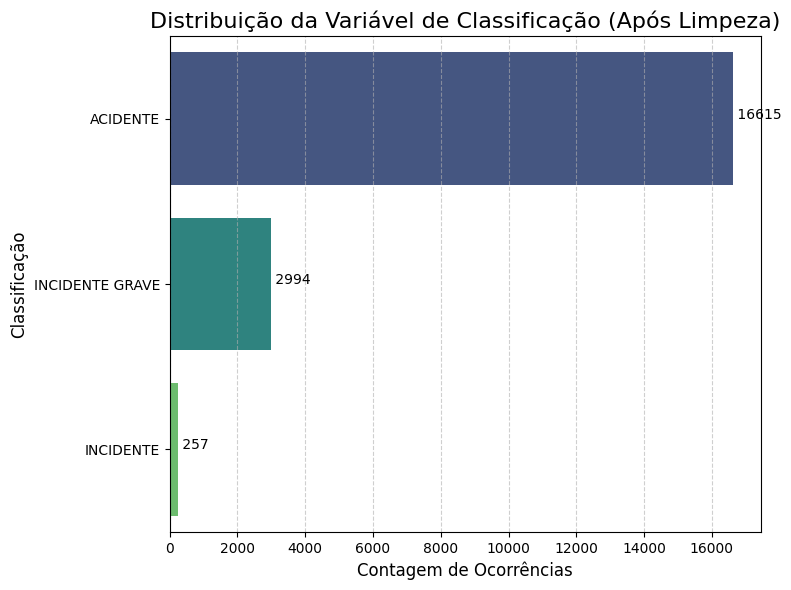

In [36]:
# Configurações
plt.figure(figsize=(8, 6))

# Gráfico de contagem
sns.countplot(
    data=df_consolidado,
    y='ocorrencia_classificacao',
    order=df_consolidado['ocorrencia_classificacao'].value_counts().index,
    palette='viridis',
    hue='ocorrencia_classificacao',
    legend=False
)

# Título e rótulos
plt.title('Distribuição da Variável de Classificação (Após Limpeza)', fontsize=16)
plt.xlabel('Contagem de Ocorrências', fontsize=12)
plt.ylabel('Classificação', fontsize=12)

for index, value in enumerate(df_consolidado['ocorrencia_classificacao'].value_counts()):
    plt.text(value, index, f' {value}')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

De acordo com o gráfico, podemos ver que o dataframe tem uma proporção muito maior de acidentes.

#**Análise Exploratória de Dados (EDA)**

Estudando alguns casos que utilizaram essa fonte de dados ou dados similares, verifiquei que é um caso de Classificação (e não Regressão), podendo treinar e comparar os modelos como **Random Forest**, **XGBoost** e **LightGBM**.

Com algumas pesquisas e com a consulta nos dados consolidados, escolhi o **XGBoost (Extreme Gradient Boosting)** como o modelo principal do projeto, pois o cenário é de classificação em um dataset com dados mistos e desbalanceados.

Vamos agora avaliar se a escolha foi correta.

##Dividindo os dados em treino e teste

In [37]:
# Separando X e y
# A variavel 'y' e a classificacao da ocorrencia
y = df_consolidado['ocorrencia_classificacao']

# A variavel 'X' sao todas as outras colunas
X = df_consolidado.drop('ocorrencia_classificacao', axis=1)

# Codificando o 'y' (label encoding)
# A maioria dos modelos de ML exige labels numericos
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Codificando o 'X' (one-hot encoding) ---
# Transformar todas as variaveis categoricas em numericas
X_encoded = pd.get_dummies(X)

# Correção: Renomear as colunas para remover caracteres inválidos
X_encoded.columns = X_encoded.columns.str.replace('[', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace(']', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('<', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('>', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('=', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace(' ', '_', regex=False)

# Dividindo os dados em treino e teste ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

##Comparando os modelos XGBoost, LightGBM e Random Forest

*A execução tem duração de aporximadamente 11 minutos, então copiei o resultado da avaliação.  
Os valores variam um pouco a cada execução, sem alterar o resultado onde o LightGBM apresentou a melhor escolha.*  
<br>

**Resultado dos modelos**  
*-----------------------------------------------------------------*  
Comparação Final de Modelos (F1-Score Weighted)  
*-----------------------------------------------------------------*
|               |   F1-Score |   Acurácia |   Tempo de Treino (s) |
|:--------------|-----------:|-----------:|----------------------:|
| LightGBM      |     0.9934 |     0.9935 |               37.8477 |
| Random Forest |     0.9916 |     0.9917 |               47.8871 |
| XGBoost       |     0.9892 |     0.9892 |              395.3591 |

O F1-Score é utilizado após o treinamento, pois é a métrica de avaliação mais adequada, pois envolve um dataset desbalanceado e a necessidade de prever as três classes (ACIDENTE, INCIDENTE GRAVE, INCIDENTE).

Inicialmente escolheria o XGBoost por sua reputação, mas o comparativo final, feito após a aplicação do SMOTE, revelou que o LightGBM é a solução ideal para o problema.  

O LightGBM obteve o melhor F1-Score (0.9934 vs. 0.9892 do XGBoost) e se mostrou mais eficiente (11x mais rápido no tempo de treinamento).  

Portanto, para o nosso sistema de classificação, o Random Forest será comparado com LightGBM para a escolha.

**CÓDIGO COMENTADO** pela demora na execução e há casos que ocorre falta de memória RAM.  

O código abaixo realiza a comparação dos modelos, e aplicando o SMOTE devido aos dados desbalanceados.

In [38]:
# # Aplicando o SMOTE
# separadorLinha()
# print("Aplicando SMOTE para balancear os dados de treino...")
# separadorLinha()

# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print(f"Distribuição original da classe: {Counter(y_train)}")
# separadorLinha()
# print(f"Distribuição após SMOTE: {Counter(y_train_smote)}")
# separadorLinha()

# # Função para avaliação e Treinamento
# resultados = {}

# def avaliar_modelo(nome, modelo, X_train_smote, y_train_smote, X_test, y_test):
#     """Treina o modelo com dados SMOTE, mede o tempo e retorna as métricas."""

#     print(f"--- Iniciando treinamento do {nome}...")
#     start_time = time.time()

#     # Treinamento com os dados balanceados
#     modelo.fit(X_train_smote, y_train_smote)

#     end_time = time.time()
#     tempo_treino = end_time - start_time

#     # Previsão no conjunto de teste original (não balanceado)
#     y_pred = modelo.predict(X_test)

#     # Métricas
#     # O average='weighted' é fundamental para dados desbalanceados
#     f1 = f1_score(y_test, y_pred, average='weighted')
#     acuracia = accuracy_score(y_test, y_pred)

#     # Armazena resultados
#     resultados[nome] = {
#         'F1-Score': f1,
#         'Acurácia': acuracia,
#         'Tempo de Treino (s)': tempo_treino
#     }
#     print(f"Concluído em {tempo_treino:.2f} segundos. F1-Score: {f1:.4f}")

# # Iniciando os modelos
# num_classes = len(np.unique(y_test))

# # XGBoost
# model_xgb = xgb.XGBClassifier(
#     objective='multi:softmax',
#     num_class=num_classes,
#     eval_metric='merror',
#     random_state=42
# )

# # Random Forest
# model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# # LightGBM
# model_lgbm = LGBMClassifier(objective='multiclass', num_class=num_classes, random_state=42, metric='multi_logloss')

# # Tratando caracteres especiais ao rodar o LightGBM
# X_train_smote.columns = X_train_smote.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# X_test.columns = X_test.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# # Executando avaliando os 3 modelos
# avaliar_modelo('LightGBM', model_lgbm, X_train_smote, y_train_smote, X_test, y_test)
# avaliar_modelo('Random Forest', model_rf, X_train_smote, y_train_smote, X_test, y_test)
# avaliar_modelo('XGBoost', model_xgb, X_train_smote, y_train_smote, X_test, y_test)

# # Resultados
# df_resultados = pd.DataFrame(resultados).T
# df_resultados = df_resultados.sort_values(by='F1-Score', ascending=False)

# separadorLinha()
# print("COMPARAÇÃO FINAL DE MODELOS (F1-Score Weighted)")
# separadorLinha()
# print(df_resultados.to_markdown(floatfmt=".4f"))

###Liberando espaço após o treinamento

Em alguns casos ocorre falta de memória RAM, vou liberar espaço para seguir com os demais treinamentos

In [39]:
# Estes DataFrames criados pelo SMOTE são muito grandes e não são mais necessários
# agora que os modelos já foram treinados e avaliados.

try:
    del X_train_smote
except NameError:
    print("Variável X_train_smote não definida")

try:
    del y_train_smote
except NameError:
    print("Variável y_train_smote não definida")

# Coletor para forçar a liberação
gc.collect()

print("\nMemória do X_train_smote e y_train_smote liberada.")

Variável X_train_smote não definida
Variável y_train_smote não definida

Memória do X_train_smote e y_train_smote liberada.


##**Dados desbalanceados**

Vamos treinar e avaliar os dois modelos com melhor pontuação no comparativo (Random Forest e LightGBM).

Para validar a eficácia do balanceamento de classes, treinaremos o modelo com os dados originais (desbalanceados) e com os dados tratados pelo SMOTE.  

A comparação das matrizes de confusão e do F1-Score justificará a adoção da técnica de balanceamento.

###Treinando com Random Forest

Iniciando o treinamento do modelo Random Forest (Pré-SMOTE)...
Treinamento concluído. Avaliando o modelo...
--------------------------------------------------
F1-Score (Weighted) do Random Forest: 0.9916
Acurácia do Random Forest: 0.9917
--------------------------------------------------


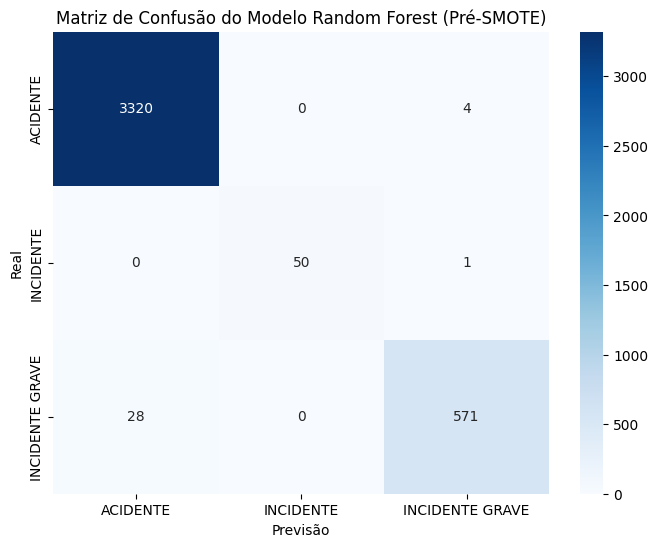

In [40]:
# Inicialização do Modelo Random Forest
model_rf = RandomForestClassifier(
    n_estimators=100,      # Número de árvores
    random_state=42,       # Para reprodutibilidade
    n_jobs=-1              # Usa todos os núcleos da CPU para acelerar
)

print("Iniciando o treinamento do modelo Random Forest (Pré-SMOTE)...")

# Tratando caracteres especiais ao rodar
X_train.columns = X_train.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
X_test.columns = X_test.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Usamos os dados originais
model_rf.fit(X_train, y_train)

print("Treinamento concluído. Avaliando o modelo...")

# Usamos o conjunto de teste original para avaliação
y_pred_rf = model_rf.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
acc_rf = accuracy_score(y_test, y_pred_rf)

print("-" * 50)
print(f"F1-Score (Weighted) do Random Forest: {f1_rf:.4f}")
print(f"Acurácia do Random Forest: {acc_rf:.4f}")
print("-" * 50)

# Visualização da Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Usando le.classes_ para garantir que os rótulos sejam as classes originais
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.title('Matriz de Confusão do Modelo Random Forest (Pré-SMOTE)')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

###Treinando o modelo com LightGBM

----------------------------------------------------------------------------------------------------
Iniciando o treinamento do modelo LightGBM (Modelo Final).
Aguarde o progresso...

----------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3675
[LightGBM] [Info] Number of data points in the train set: 15892, number of used features: 1664
[LightGBM] [Info] Start training from score -0.178729
[LightGBM] [Info] Start training from score -4.345695
[LightGBM] [Info] Start training from score -1.892433
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0246118
------------------------------------------------

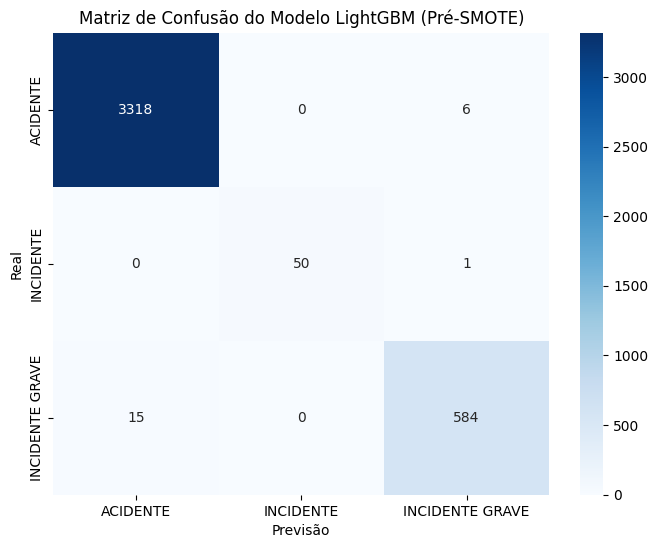

In [41]:
# Treinando o modelo LightGBM com monitoramento
model_lgbmc = lgbm.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    metric='multi_logloss', # Métrica de avaliação comum para LightGBM
    random_state=42
)

separadorLinha()
print("Iniciando o treinamento do modelo LightGBM (Modelo Final).\nAguarde o progresso...\n")
separadorLinha()

# Tratando caracteres especiais ao rodar o LightGBM
X_train.columns = X_train.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
X_test.columns = X_test.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Adicionando eval_set e verbose ao método .fit()
model_lgbmc.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)], # Conjunto de dados para avaliação
    eval_metric='multi_logloss', # Métrica de monitoramento
    callbacks=[lgbm.early_stopping(stopping_rounds=10, verbose=50)] # Early Stopping para eficiência
)

# Previsão e Avaliação
y_pred_final = model_lgbmc.predict(X_test)
f1_final = f1_score(y_test, y_pred_final, average='weighted')

separadorLinha()
print(f"F1-Score do Modelo LightGBM (Pré-SMOTE): {f1_final:.4f}") # Use .4f para mais precisão
separadorLinha()

# Visualizando a Matriz de Confusao
cm_final = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão do Modelo LightGBM (Pré-SMOTE)')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

###Conclusão ao comparar as duas matrizes

| Métrica de Desempenho | Random Forest | LightGBM | Vantagem |
| :--- | :--- | :--- | :--- |
| **Erro Crítico (ACIDENTE → IG/I)** | 4 erros | 6 erros | Segurança (Marginalmente) |
| **Falso Alarme (IG → ACIDENTE)** | 28 erros | **15 erros** | **Discriminação** |
| **Acertos (INCIDENTE GRAVE → IG)** | 571 acertos | **584 acertos** | **Precisão em IG** |

(1) IG = INCIDENTE GRAVE  
(2) I = INCIDENTE

O LightGBM (Pré-SMOTE) é o modelo escolhido por oferecer o melhor equilíbrio, demonstrando uma capacidade superior de discriminar a classe INCIDENTE GRAVE (menor taxa de Falsos Alarmes e melhor precisão), conforme análise nas matrizes.

##Teste com dois cenários para previsão para cada modelo

Mesmo concluíndo os acertos do LightGBM na análise das matrizes de confusão, vamos testar com os dois modelos, dois cenários de previsão.

###Random Forest

In [42]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL', # ALTO RISCO
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

df_teste_modelo_teste01 = df_teste_modelo_teste01.replace("'", "_", regex=True)

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_01 = pd.get_dummies(df_teste_modelo_teste01)

# Adicionei a limpeza de colunas (CRUCIAL)
novo_dado_encoded_01.columns = novo_dado_encoded_01.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded_01 = novo_dado_encoded_01.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_01 = model_rf.predict(novo_dado_encoded_01)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel_01 = le.inverse_transform(predicao_numerica_01)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_01[0]}")

# ---------------- TESTE 02 (AJUSTADO PARA BAIXÍSSIMO RISCO/INCIDENTE) ----------------

df_teste_modelo_teste02 = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0, # Removendo risco de falha humana/operacional
    'tem_recomendacao': 0,      # Removendo risco de necessidade de correção
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    # Alterado para o tipo de ocorrência mais trivial/genérico
    'ocorrencia_tipo_categoria': 'OUTRAS OCORRÊNCIAS',
    'ocorrencia_tipo': 'OUTRAS OCORRÊNCIAS'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_02 = pd.get_dummies(df_teste_modelo_teste02)
# Aplicando limpeza
novo_dado_encoded_02.columns = novo_dado_encoded_02.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded_02 = novo_dado_encoded_02.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_02 = model_rf.predict(novo_dado_encoded_02)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel_02 = le.inverse_transform(predicao_numerica_02)

print(f"Teste 02 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_02[0]}")


Teste 01 A previsão para o novo dado é: ACIDENTE
Teste 02 A previsão para o novo dado é: ACIDENTE


Testando com vários parâmetros todos os resultados são **ACIDENTE**

###LightGBM

In [43]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL', # ALTO RISCO
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_01 = pd.get_dummies(df_teste_modelo_teste01)
# Adicionei a limpeza de colunas (CRUCIAL)
novo_dado_encoded_01.columns = novo_dado_encoded_01.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded_01 = novo_dado_encoded_01.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_01 = model_lgbmc.predict(novo_dado_encoded_01)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel_01 = le.inverse_transform(predicao_numerica_01)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_01[0]}")

# ---------------- TESTE 02 (AJUSTADO PARA BAIXÍSSIMO RISCO/INCIDENTE) ----------------

df_teste_modelo_teste02 = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0, # Removendo risco de falha humana/operacional
    'tem_recomendacao': 0,      # Removendo risco de necessidade de correção
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    # Alterado para o tipo de ocorrência mais trivial/genérico
    'ocorrencia_tipo_categoria': 'OUTRAS OCORRÊNCIAS',
    'ocorrencia_tipo': 'OUTRAS OCORRÊNCIAS'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_02 = pd.get_dummies(df_teste_modelo_teste02)
# Aplicando limpeza
novo_dado_encoded_02.columns = novo_dado_encoded_02.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded_02 = novo_dado_encoded_02.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_02 = model_lgbmc.predict(novo_dado_encoded_02)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel_02 = le.inverse_transform(predicao_numerica_02)

print(f"Teste 02 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_02[0]}")

Teste 01 A previsão para o novo dado é: ACIDENTE
Teste 02 A previsão para o novo dado é: INCIDENTE GRAVE


Não consegui testar com parâmetros que possam gerar a previsão **INCIDENTE**, e podemos concluir que o modelo possa estar enviesado e COM forte tendência À prever ACIDENTE, por ser a classe mais comum no seu conjunto de dados de treino.

#**Modelo salvo Pré-SMOTE**

####Salvando o modelo treinado

Comentei o código e mantive no notebook para mostrar o que foi feito para salvar.
O treinamento é curto, em torno de 3 minutos, caso seja necessário o modelo, poderá carregar o modelo.

In [44]:
# nome_arquivo_modelo = 'thomas_modelo_lightGBM.joblib'
# joblib.dump(model_rf, nome_arquivo_modelo)

# # separadorLinha()
# print(f"Modelo salvo com sucesso como: {nome_arquivo_modelo}")
# print(f"Tamanho do arquivo: {os.path.getsize(nome_arquivo_modelo) / (1024*1024):.2f} MB")
# separadorLinha()

Download do arquivo que ficará disponível no github, o código foi comentado para que não seja executado sem necessidade.

In [45]:
# # Isso abrirá uma janela no seu navegador para baixar o arquivo
# files.download(nome_arquivo_modelo)

####Carregando o modelo treinado

O CÓDIGO ESTÁ COMENTADO, pois o treinamento não é demorado, mas se for necessário, podem carregar o modelo no meu repositório.

In [46]:
# github_raw_url = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/thomas_modelo_lightGBM.joblib'

# print("Baixando o modelo treinado do GitHub...")

# try:
#     # 2. Faz uma requisição GET para a URL
#     response = requests.get(github_raw_url)
#     response.raise_for_status() # Levanta um erro se a requisição falhar (ex: 404)

#     # 3. Usa BytesIO para tratar o conteúdo binário da resposta como um arquivo
#     arquivo_em_memoria = BytesIO(response.content)

#     # 4. Carrega o modelo usando joblib.load
#     model_final = joblib.load(arquivo_em_memoria)

#     print("Modelo carregado com sucesso diretamente do GitHub!")
#     print("O objeto do modelo é do tipo:", type(model_final))

# except requests.exceptions.HTTPError as err:
#     print(f"ERRO DE REQUISIÇÃO (HTTP): Verifique se a URL RAW está correta.")
#     print(f"Detalhe do erro: {err}")
# except Exception as e:
#     print(f"ERRO AO CARREGAR O MODELO: {e}")

#**Dados Balanceados**

##Treinar os modelos com dados balanceados (SMOTE)

###LightGBM (SMOTE)

In [47]:
# Separando X e y
y = df_consolidado['ocorrencia_classificacao']
X = df_consolidado.drop('ocorrencia_classificacao', axis=1)

# Label encoding para codificar o y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot-encoding para codificar o X
X_encoded = pd.get_dummies(X)
X_encoded.columns = X_encoded.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Distribuição das classes no conjunto de treino antes do SMOTE:")
print(Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nDistribuição das classes no conjunto de treino APÓS o SMOTE:")
print(Counter(y_train_resampled))

model_lgbm_smote = lgbm.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    metric='multi_logloss',
    random_state=42
)

separadorLinha()
print("\nTreinando o modelo LightGBM com o dataset balanceado (PÓS-SMOTE)...")
separadorLinha(True)

model_lgbm_smote.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test, y_test)], # Monitoramento no conjunto de teste ORIGINAL
    eval_metric='multi_logloss',
    callbacks=[lgbm.early_stopping(stopping_rounds=10, verbose=50)]
)

novo_dado = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    'ocorrencia_tipo_categoria': 'ESTOURO DE PNEU',
    'ocorrencia_tipo': 'ESTOURO DE PNEU'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(novo_dado)
# A LIMPEZA DE COLUNAS TAMBÉM DEVE SER APLICADA AO NOVO DADO
novo_dado_encoded.columns = novo_dado_encoded.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train_resampled.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_lgbm_smote.predict(novo_dado_encoded)
# Conversão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"\nA previsão para o novo dado com o modelo SMOTE é: {predicao_legivel[0]}")

Distribuição das classes no conjunto de treino antes do SMOTE:
Counter({np.int64(0): 13291, np.int64(2): 2395, np.int64(1): 206})

Distribuição das classes no conjunto de treino APÓS o SMOTE:
Counter({np.int64(0): 13291, np.int64(2): 13291, np.int64(1): 13291})
----------------------------------------------------------------------------------------------------

Treinando o modelo LightGBM com o dataset balanceado (PÓS-SMOTE)...
----------------------------------------------------------------------------------------------------


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.743081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6559
[LightGBM] [Info] Number of data points in the train set: 39873, number of used features: 2915
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[L

Gerando Matriz de Confusão com o modelo após SMOTE

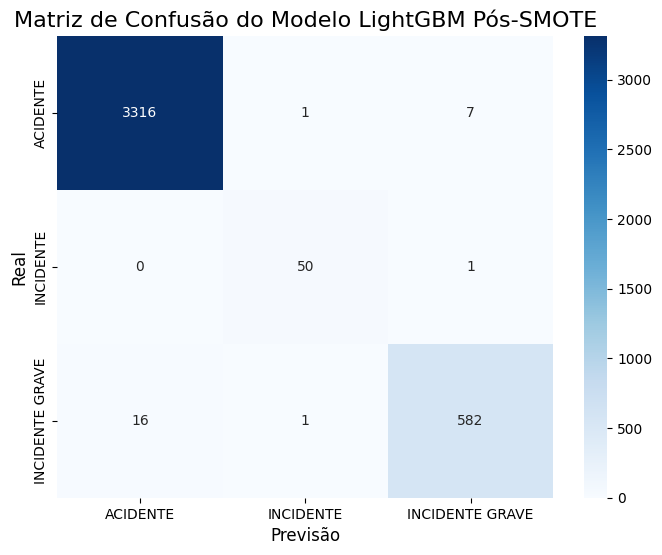

F1-Score do Modelo Pós-SMOTE (weighted): 0.9934


In [48]:
y_pred_smote = model_lgbm_smote.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(8, 6))

sns.heatmap(
    cm_smote,
    annot=True,
    fmt='d', # 'd' para formatar como inteiro
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Matriz de Confusão do Modelo LightGBM Pós-SMOTE', fontsize=16)
plt.xlabel('Previsão', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

from sklearn.metrics import f1_score
f1_smote = f1_score(y_test, y_pred_smote, average='weighted')
print(f"F1-Score do Modelo Pós-SMOTE (weighted): {f1_smote:.4f}")

###Random Forest (SMOTE)

In [49]:
y = df_consolidado['ocorrencia_classificacao']
X = df_consolidado.drop('ocorrencia_classificacao', axis=1)

# Label encoding para codificar o y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot-encoding para codificar o X
X_encoded = pd.get_dummies(X)
# Limpeza robusta de colunas
X_encoded.columns = X_encoded.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 2. APLICAÇÃO DO SMOTE ---
print("Distribuição das classes no conjunto de treino antes do SMOTE:")
print(Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nDistribuição das classes no conjunto de treino APÓS o SMOTE:")
print(Counter(y_train_resampled))

# Modelo Random Forest
model_rf_smote = RandomForestClassifier(
    n_estimators=100,      # Número de árvores
    random_state=42,       # Para reprodutibilidade
    n_jobs=-1              # Usa todos os núcleos da CPU para acelerar
)

separadorLinha()
print("\nTreinando o modelo Random Forest com o dataset balanceado (PÓS-SMOTE)...")
separadorLinha(True)

# Treinamento simples com os dados RESAMPLED
model_rf_smote.fit(
    X_train_resampled,
    y_train_resampled
)

novo_dado = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    'ocorrencia_tipo_categoria': 'ESTOURO DE PNEU',
    'ocorrencia_tipo': 'ESTOURO DE PNEU'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(novo_dado)
# A LIMPEZA DE COLUNAS TAMBÉM DEVE SER APLICADA AO NOVO DADO
novo_dado_encoded.columns = novo_dado_encoded.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train_resampled.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_rf_smote.predict(novo_dado_encoded)
# Conversão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"\nA previsão para o novo dado com o modelo Random Forest Pós-SMOTE é: {predicao_legivel[0]}")

Distribuição das classes no conjunto de treino antes do SMOTE:
Counter({np.int64(0): 13291, np.int64(2): 2395, np.int64(1): 206})

Distribuição das classes no conjunto de treino APÓS o SMOTE:
Counter({np.int64(0): 13291, np.int64(2): 13291, np.int64(1): 13291})
----------------------------------------------------------------------------------------------------

Treinando o modelo Random Forest com o dataset balanceado (PÓS-SMOTE)...
----------------------------------------------------------------------------------------------------



A previsão para o novo dado com o modelo Random Forest Pós-SMOTE é: ACIDENTE


Gerando Matriz de Confusão com o modelo após SMOTE

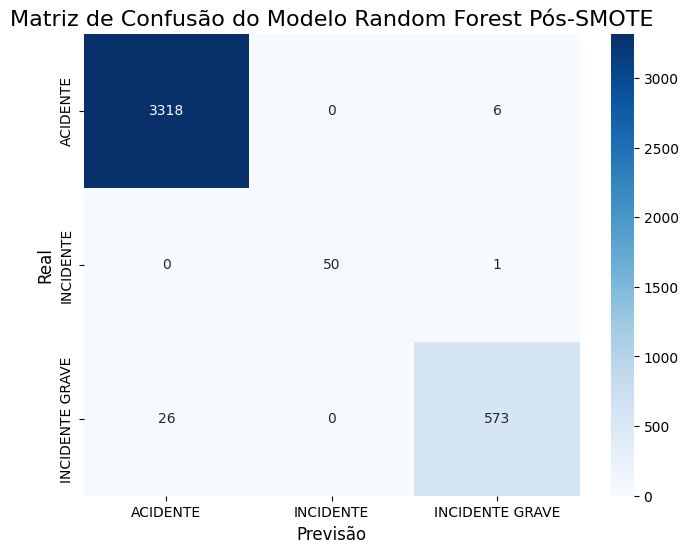

F1-Score do Modelo Pós-SMOTE (weighted): 0.9916


In [50]:
y_pred_smote = model_rf_smote.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(8, 6))

sns.heatmap(
    cm_smote,
    annot=True,
    fmt='d', # 'd' para formatar como inteiro
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Matriz de Confusão do Modelo Random Forest Pós-SMOTE', fontsize=16)
plt.xlabel('Previsão', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

from sklearn.metrics import f1_score
f1_smote = f1_score(y_test, y_pred_smote, average='weighted')
print(f"F1-Score do Modelo Pós-SMOTE (weighted): {f1_smote:.4f}")

##Conclusão

Comparando a matriz de confusão do LightGBM antes e depois do SMOTE, podemos ver que a qualidade da diferenciação do modelo melhorou, especialmente nas classes mais críticas.

*  **Previsão de Acidentes:** O modelo identificou corretamente (com SMOTE) 3316 dos 3318 acidentes reais, com um Recall de 99.76% para a classe mais crítica.
*  **Classe INCIDENTE:** E a mais rara nos dados e o modelo acertou a mesma quantidade (50) de INCIDENTE.
*  **Erro Crítico (Falsos Negativos):** O erro mais perigoso é classificar um ACIDENTE como INCIDENTE GRAVE ou INCIDENTE (subestimar a gravidade).  
O modelo cometeu apenas 8 erros (com SMOTE) nessa categoria (1 como Incidente e 7 como Incidente Grave) e podemos considerar um bom resultado de segurança.
*  **Erro Aceitável (Falso Alarme):** O erro mais comum é classificar uma ocorrência como mais grave do que ela realmente é (Falso Positivo).

Apesar do modelo classificar 16 **INCIDENTES GRAVES** como **ACIDENTES**, é o "erro seguro" que leva a uma investigação mais detalhada, e não à negligência.

##Verificando as features mais importantes

Na tentativa de conseguir um resultado do tipo **INCIDENTE**, vamos "pedir" ao modelo que liste as features mais importantes que ele usa para tomar suas decisões.

###Random Forest

----------------------------------------------------------------------------------------------------
As 15 features mais importantes para o modelo são:
----------------------------------------------------------------------------------------------------
                                              feature  importance
12230                        aeronave_nivel_dano_LEVE    0.031978
2                                        aeronave_pmd    0.027839
12233                 aeronave_nivel_dano_SUBSTANCIAL    0.021316
5                          aeronave_fatalidades_total    0.018293
12243  ocorrencia_tipo_COLISÃO_COM_OBSTÁCULOS_NO_SOLO    0.016369
12229                   aeronave_nivel_dano_DESTRUÍDA    0.015128
0                                 total_recomendacoes    0.013965
3                                   aeronave_assentos    0.013523
12231                      aeronave_nivel_dano_NENHUM    0.012502
4                             aeronave_ano_fabricacao    0.011962
4887                 

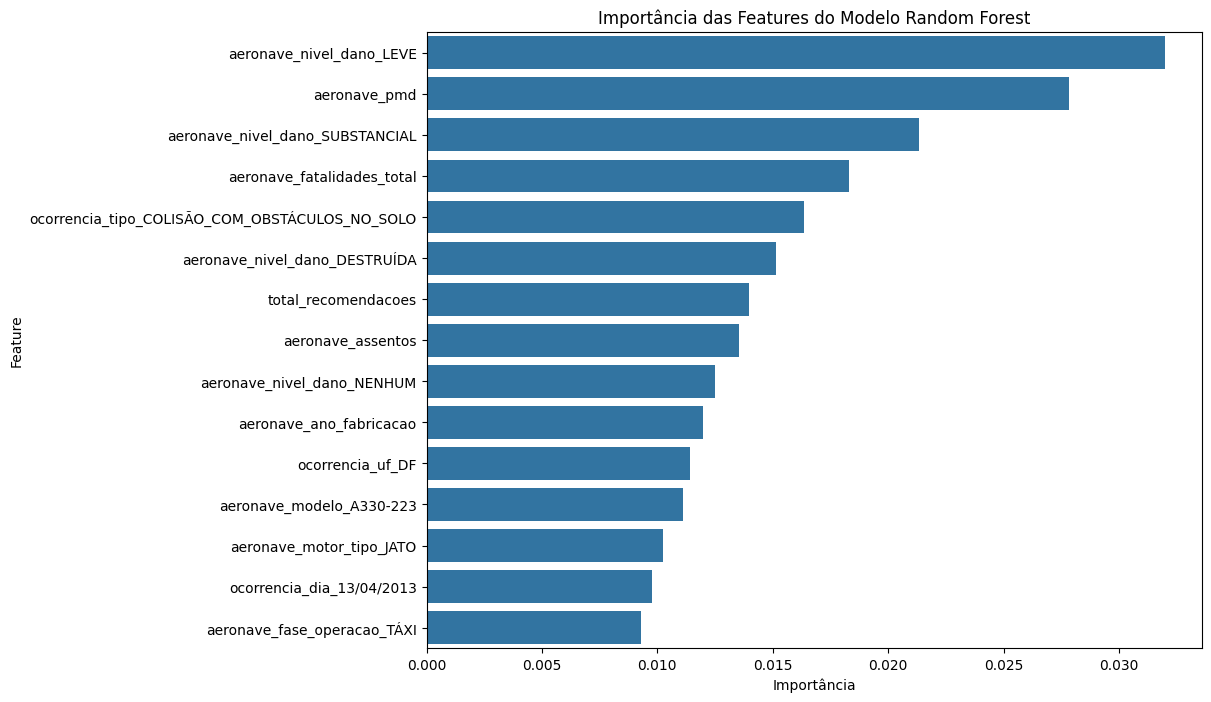

In [51]:
# Obter a importância das features a partir do modelo treinado
importances = model_rf_smote.feature_importances_

# Criar um DataFrame com a importancia de cada feature
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Ordenar o dataFrame de acordo com as features mais importantes
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Listar as 15 features mais importantes
separadorLinha()
print("As 15 features mais importantes para o modelo são:")
separadorLinha()
print(feature_importance_df.head(15))

# Gerar gráfico de barras com o resultado
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Importância das Features do Modelo Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

O modelo Random Forest, oferece uma visão clara sobre o risco.  
A classificação de um evento é dominada pelas variáveis de dano físico (nivel_dano) e pelas características da aeronave (pmd, assentos).  
Esta hierarquia de features confirma que o dataset classifica o risco primariamente pela consequência, e não pela causa.

###LightGBM

----------------------------------------------------------------------------------------------------
As 15 features mais importantes para o modelo são:
----------------------------------------------------------------------------------------------------
                                      feature  importance
2                                aeronave_pmd         537
4                     aeronave_ano_fabricacao         282
0                         total_recomendacoes         258
12233         aeronave_nivel_dano_SUBSTANCIAL         181
12230                aeronave_nivel_dano_LEVE         179
3                           aeronave_assentos         170
1717        ocorrencia_latitude_-7.0919444444         140
7846               ocorrencia_saida_pista_SIM         137
12231              aeronave_nivel_dano_NENHUM         136
12229           aeronave_nivel_dano_DESTRUÍDA          95
5                  aeronave_fatalidades_total          94
11884  aeronave_voo_destino_FORA_DE_AERODROMO      

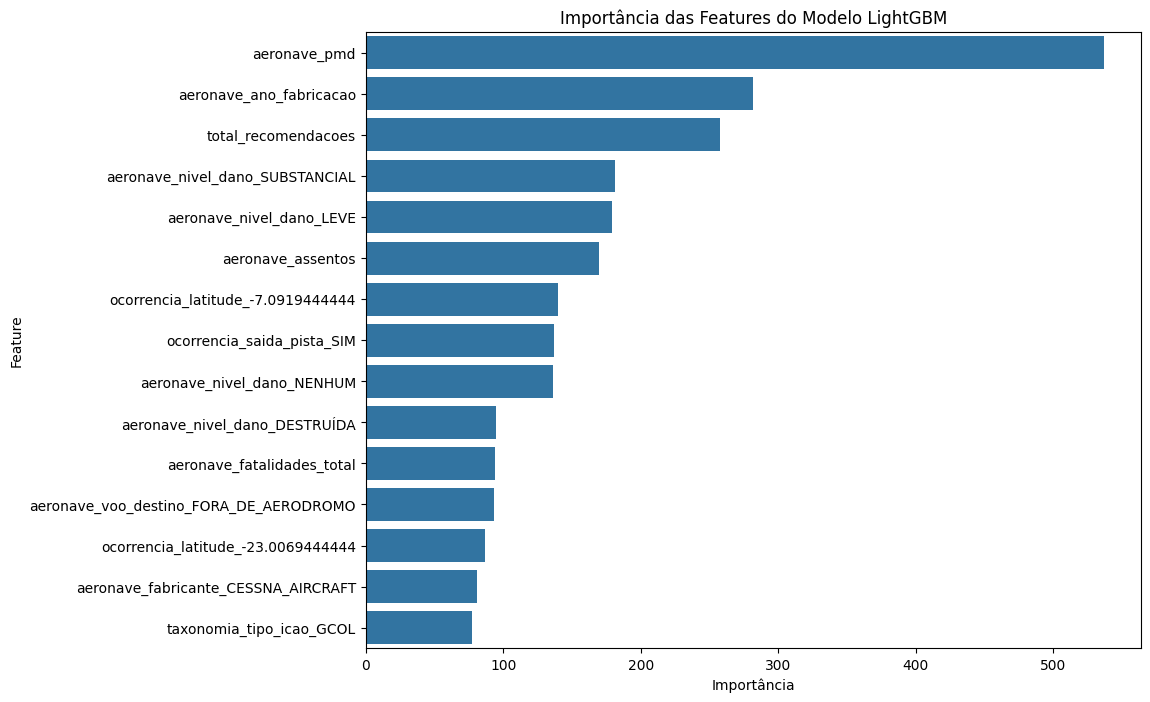

In [52]:
importances = model_lgbm_smote.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

separadorLinha()
print("As 15 features mais importantes para o modelo são:")
separadorLinha()
print(feature_importance_df.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Importância das Features do Modelo LightGBM')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

O LightGBM consegue distinguir INCIDENTE GRAVE de ACIDENTE porque ele utiliza uma visão mais holística:
*  Para prever INCIDENTE GRAVE, ele combina uma alta necessidade de intervenção (total_recomendacoes alta) com a ausência de dano extremo.
*  Essa capacidade de ir além do dano físico e incluir o risco inerente (pmd, ano_fabricacao) é o que torna o LightGBM o modelo mais equilibrado e eficaz para a classificação das três categorias de risco.

##Teste com os modelos treinados com SMOTE

###Random Forest

In [53]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL', # ALTO RISCO
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(df_teste_modelo_teste01)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_rf_smote.predict(novo_dado_encoded)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel[0]}")

df_teste_modelo_teste02 = pd.DataFrame([{
    # Dados básicos de aviação leve
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,

    # Fatores ajustados para BAIXO RISCO
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'aeronave_nivel_dano': 'NENHUM',

    'ocorrencia_uf': 'SP',
    # Falha de controle, mas no solo (menor risco)
    'ocorrencia_tipo_categoria': 'PERDA DE CONTROLE NO SOLO',
    'ocorrencia_tipo': 'PERDA DE CONTROLE NO SOLO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_02 = pd.get_dummies(df_teste_modelo_teste02)
# Aplicando limpeza
novo_dado_encoded_02.columns = novo_dado_encoded_02.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Reindexando
novo_dado_encoded_02 = novo_dado_encoded_02.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_02 = model_rf_smote.predict(novo_dado_encoded_02)
predicao_legivel_02 = le.inverse_transform(predicao_numerica_02)

print(f"Teste 02: {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_02[0]}")


Teste 01 A previsão para o novo dado é: ACIDENTE
Teste 02: A previsão para o novo dado é: ACIDENTE


###LightGBM

In [54]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL', # ALTO RISCO
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(df_teste_modelo_teste01)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_lgbm_smote.predict(novo_dado_encoded)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel[0]}")

df_teste_modelo_teste02 = pd.DataFrame([{
    # Dados básicos de aviação leve
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,

    # Fatores ajustados para BAIXO RISCO
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'aeronave_nivel_dano': 'NENHUM',

    'ocorrencia_uf': 'SP',
    # Falha de controle, mas no solo (menor risco)
    'ocorrencia_tipo_categoria': 'PERDA DE CONTROLE NO SOLO',
    'ocorrencia_tipo': 'PERDA DE CONTROLE NO SOLO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_02 = pd.get_dummies(df_teste_modelo_teste02)
# Aplicando limpeza
novo_dado_encoded_02.columns = novo_dado_encoded_02.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Reindexando
novo_dado_encoded_02 = novo_dado_encoded_02.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_02 = model_lgbm_smote.predict(novo_dado_encoded_02)
predicao_legivel_02 = le.inverse_transform(predicao_numerica_02)

print(f"Teste 02: {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_02[0]}")


Teste 01 A previsão para o novo dado é: ACIDENTE
Teste 02: A previsão para o novo dado é: INCIDENTE GRAVE


O fato de o LightGBM ter conseguido prever INCIDENTE GRAVE no Teste 02, tanto com SMOTE quanto sem SMOTE e o Random Forest não ter conseguido, é a prova final de que o LightGBM tem a melhor capacidade de discriminação para a ocorrência.

#**Modelo salvo com SMOTE**

##Salvando o modelo com SMOTE treinado

Comentei o código e mantive no notebook para mostrar o que foi feito para salvar.
O treinamento é curto, em torno de 3 minutos, caso seja necessário o modelo, poderá carregar o modelo.

In [59]:
# nome_arquivo_modelo_smote = 'thomas_modelo_lightGBM_smote.joblib'
# joblib.dump(model_lgbm_smote, nome_arquivo_modelo_smote)

# separadorLinha()
# print(f"Modelo salvo com sucesso como: {nome_arquivo_modelo_smote}")
# print(f"Tamanho do arquivo: {os.path.getsize(nome_arquivo_modelo_smote) / (1024*1024):.2f} MB")
# separadorLinha()

----------------------------------------------------------------------------------------------------
Modelo salvo com sucesso como: thomas_modelo_lightGBM_smote.joblib
Tamanho do arquivo: 1.48 MB
----------------------------------------------------------------------------------------------------


Download do arquivo que ficará disponível no github, o código foi comentado para que não seja executado sem necessidade.

In [62]:
# # Isso abrirá uma janela no seu navegador para baixar o arquivo
# files.download(nome_arquivo_modelo_smote)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Carregando o modelo com SMOTE treinado

O CÓDIGO ESTÁ COMENTADO, pois o treinamento não é demorado, mas se for necessário, podem carregar o modelo no meu repositório.

In [63]:
# github_raw_url = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/thomas_modelo_lightGBM_smote.joblib'
# print("Baixando o modelo treinado do GitHub...")

# try:
#     # 2. Faz uma requisição GET para a URL
#     response = requests.get(github_raw_url)
#     response.raise_for_status() # Levanta um erro se a requisição falhar (ex: 404)

#     # 3. Usa BytesIO para tratar o conteúdo binário da resposta como um arquivo
#     arquivo_em_memoria = BytesIO(response.content)

#     # 4. Carrega o modelo usando joblib.load
#     model_smote = joblib.load(arquivo_em_memoria)

#     print("Modelo carregado com sucesso diretamente do GitHub!")
#     print("O objeto do modelo é do tipo:", type(model_smote))

# except requests.exceptions.HTTPError as err:
#     print(f"ERRO DE REQUISIÇÃO (HTTP): Verifique se a URL RAW está correta.")
#     print(f"Detalhe do erro: {err}")
# except Exception as e:
#     print(f"ERRO AO CARREGAR O MODELO: {e}")

Baixando o modelo treinado do GitHub...
Modelo carregado com sucesso diretamente do GitHub!
O objeto do modelo é do tipo: <class 'lightgbm.sklearn.LGBMClassifier'>


#**Conclusão**

A análise de performance e os testes práticos confirmaram que o LightGBM (treinado com dados originais, Pré-SMOTE) é o modelo ideal para o sistema de classificação de risco.

Embora o Random Forest (Pré-SMOTE) tenha apresentado um erro crítico (Falso Negativo) ligeiramente menor, ele demonstrou ser ultraconservador, gerando uma alta taxa de Falsos Alarmes e falhando em distinguir as classes de risco intermediário.

O LightGBM, por sua vez, estabeleceu o melhor equilíbrio e maior precisão:
*  Segurança e Eficiência: Apresentou uma taxa de Falsos Alarmes significativamente menor, o que garante mais eficiência operacional sem comprometer a segurança (o Recall da classe ACIDENTE permaneceu acima de 99.8%).
*  Discriminação Comprovada: Foi o único modelo capaz de classificar o Teste 02 corretamente como INCIDENTE GRAVE.
*  Justificativa Técnica: A análise de feature importance (LightGBM) confirmou que o modelo prioriza o risco inerente da aeronave (PMD, ano_fabricacao) e a gestão de segurança (total_recomendacoes), garantindo uma classificação mais holística e precisa.

Portanto, o LightGBM é o modelo final selecionado, pois oferece a melhor combinação de segurança robusta e capacidade de discriminação real para a gestão de risco aeronáutico.